# Import requirements

In [1]:
import pandas as pd
import numpy as np
import geemap, ee
import matplotlib.pyplot as plt
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

# Call VIIIRS and Tehran Shapefiles

In [2]:
viirs = ee.ImageCollection(
    "NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").select("avg_rad")
climate = ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE")
teh = ee.FeatureCollection("users/amirhkiani1998/teh").select("Asrea").geometry()

# Having a look at the clipped VIIRS!

In [4]:
gisMap = geemap.Map()
gisMap.addLayer(viirs.mean().clip(teh))
gisMap.centerObject(teh)
gisMap

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

# Getting GHSL in 2015

In [8]:
ghslList = ee.ImageCollection("JRC/GHSL/P2016/SMOD_POP_GLOBE_V1").toList(4)
ghslImage2015 = ee.Image(ghslList.get(3)) #2015-01-01

# Having a look at GHSL layer

In [12]:
gisMap = geemap.Map()
gisMap.addLayer(ghslImage2015.select("smod_code"), {
                "min": 0.0, "max": 3.0, "palette": ['000000', '448564', '70daa4', 'ffffff']})
gisMap.centerObject(teh)
gisMap


Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

# Getting VIIRS and climate in 2015 

In [13]:
viirs2015 = viirs.filterDate("2015-01-01", "2015-12-01").mean()
climate2015 = climate.filterDate("2015-01-01", "2015-12-01").mean()

# Add bands to each other

In [14]:
fusion = viirs2015.addBands(ghslImage2015).addBands(climate2015)
fusionArray = fusion.sampleRegions(collection=teh, scale=2000).getInfo()

In [15]:
mainList = fusionArray["features"]
splitDict = []
for innerDict in mainList:
    splitDict.append(innerDict["properties"])
dataframe = pd.DataFrame(splitDict)
dataframe

,aet,avg_rad,def,pdsi,pet,pr,ro,smod_code,soil,srad,swe,tmmn,tmmx,vap,vpd,vs
0,79.909091,0.120778,1493.090909,-402.181818,1572.909091,8.454545,0.363636,0,3.454545,2159.909091,0.0,133.545455,285.454545,947.181818,217.363636,284.000000
1,81.181818,0.122011,1499.636364,-398.454545,1580.818182,8.545455,0.454545,0,3.727273,2159.636364,0.0,135.363636,287.818182,963.727273,219.545455,283.818182
2,77.454545,0.099779,1490.181818,-404.818182,1567.545455,8.181818,0.363636,0,3.000000,2163.909091,0.0,132.636364,283.818182,919.181818,217.545455,283.818182
3,79.909091,0.112499,1493.090909,-402.181818,1572.909091,8.454545,0.363636,0,3.454545,2159.909091,0.0,133.545455,285.454545,947.181818,217.363636,284.000000
4,79.909091,0.116815,1493.090909,-402.181818,1572.909091,8.454545,0.363636,0,3.454545,2159.909091,0.0,133.545455,285.454545,947.181818,217.363636,284.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4217,185.090909,0.199285,529.090909,-457.181818,731.545455,18.818182,1.454545,0,147.545455,2017.363636,22.0,-28.363636,116.727273,496.909091,60.727273,210.090909
4218,187.909091,0.204424,509.909091,-459.818182,717.545455,19.000000,1.272727,0,148.181818,2021.545455,22.0,-30.636364,114.636364,487.727273,59.545455,206.090909
4219,187.909091,0.198776,509.909091,-459.818182,717.545455,19.000000,1.272727,0,148.181818,2021.545455,22.0,-30.636364,114.636364,487.727273,59.545455,206.090909
4220,185.090909,0.190985,529.090909,-457.181818,731.545455,18.818182,1.454545,0,147.545455,2017.363636,22.0,-28.363636,116.727273,496.909091,60.727273,210.090909


# Check corrletion

In [16]:
dataframe.corr().style.background_gradient(cmap="coolwarm")

,aet,avg_rad,def,pdsi,pet,pr,ro,smod_code,soil,srad,swe,tmmn,tmmx,vap,vpd,vs
aet,1.000000,0.158388,-0.624098,-0.213607,-0.571403,0.982574,0.750522,0.173754,0.459940,-0.829134,0.649285,-0.538854,-0.605441,-0.637636,-0.529833,-0.452810
avg_rad,0.158388,1.000000,0.180799,0.364202,0.202248,0.221022,0.196668,0.785679,-0.233023,-0.356301,-0.214132,0.259504,0.189464,0.239050,0.147327,0.368798
def,-0.624098,0.180799,1.000000,0.323304,0.997794,-0.515696,-0.285593,0.180420,-0.909291,0.195384,-0.820393,0.987443,0.997816,0.865091,0.978867,0.889227
pdsi,-0.213607,0.364202,0.323304,1.000000,0.317725,-0.188783,-0.038245,0.340763,-0.283712,0.169309,-0.221693,0.344485,0.343514,0.526181,0.279623,0.350739
pet,-0.571403,0.202248,0.997794,0.317725,1.000000,-0.458780,-0.238295,0.202757,-0.914136,0.135125,-0.808623,0.991751,0.997087,0.854137,0.983611,0.896620
pr,0.982574,0.221022,-0.515696,-0.188783,-0.458780,1.000000,0.761960,0.241940,0.362310,-0.884122,0.524638,-0.420613,-0.495459,-0.539126,-0.428407,-0.320597
ro,0.750522,0.196668,-0.285593,-0.038245,-0.238295,0.761960,1.000000,0.200566,0.102326,-0.753075,0.470693,-0.219205,-0.269793,-0.324713,-0.188293,-0.178332
smod_code,0.173754,0.785679,0.180420,0.340763,0.202757,0.241940,0.200566,1.000000,-0.242284,-0.383980,-0.248207,0.269659,0.193827,0.270522,0.132666,0.397383
soil,0.459940,-0.233023,-0.909291,-0.283712,-0.914136,0.362310,0.102326,-0.242284,1.000000,-0.069197,0.675524,-0.901724,-0.902591,-0.727418,-0.908549,-0.782523
srad,-0.829134,-0.356301,0.195384,0.169309,0.135125,-0.884122,-0.753075,-0.383980,-0.069197,1.000000,-0.235599,0.084464,0.172008,0.235335,0.131571,-0.051631


# Plotting the average radian against percipitation

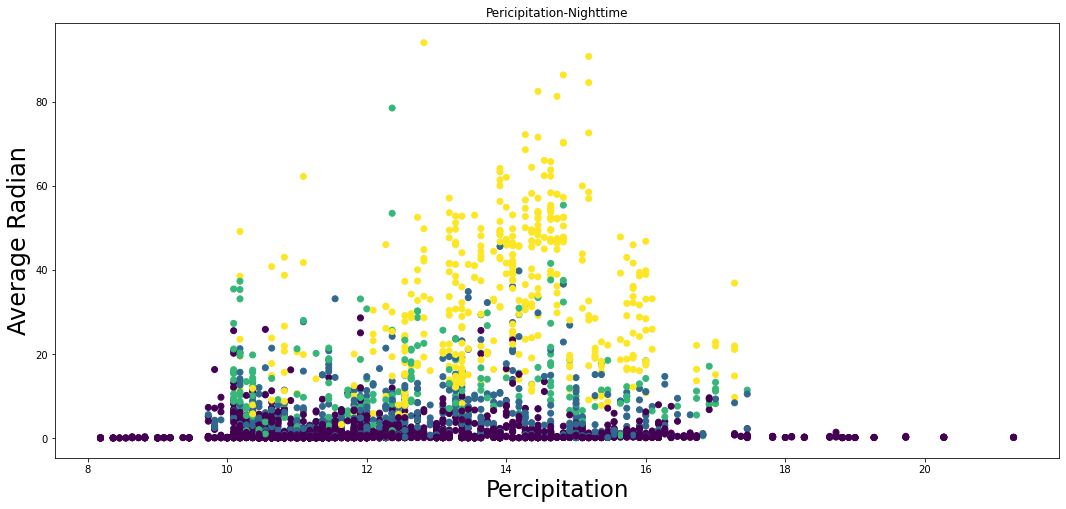

In [98]:
plt.figure(figsize=(18,8))
plt.title("Pericipitation-Nighttime")
plt.xlabel("Percipitation", fontsize=23)
plt.ylabel("Average Radian", fontsize=24)
plt.scatter(dataframe.pr, dataframe.avg_rad, c=dataframe.smod_code)
plt.show()

# Plotting the average radian against percipitation just for urban and rural

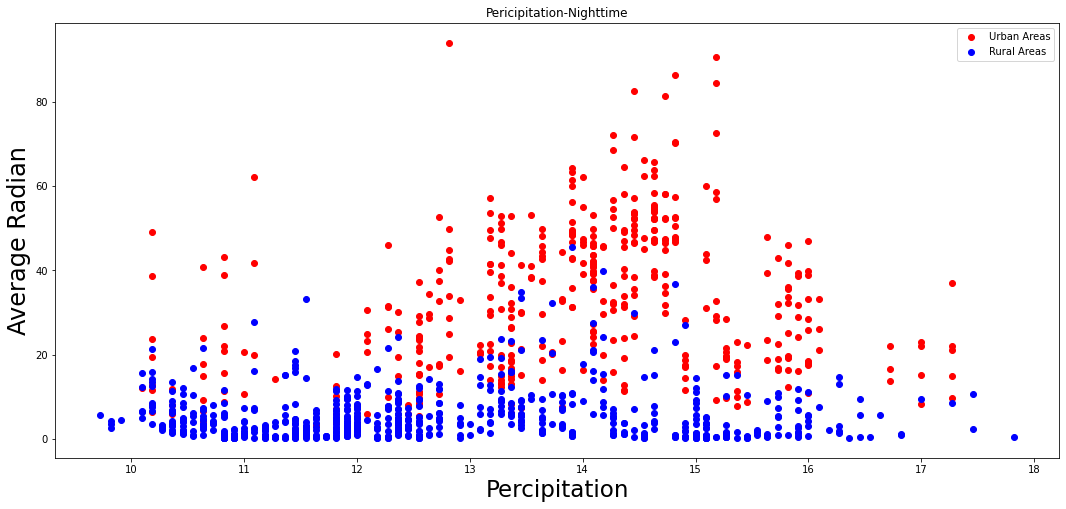

In [20]:
plt.figure(figsize=(18,8))
plt.title("Pericipitation-Nighttime")
plt.xlabel("Percipitation", fontsize=23)
plt.ylabel("Average Radian", fontsize=24)
# urban
plt.scatter(dataframe[dataframe["smod_code"] == 3].pr, dataframe[dataframe["smod_code"] == 3].avg_rad, color="red", label="Urban Areas")
# rural
plt.scatter(dataframe[dataframe["smod_code"] == 1].pr, dataframe[dataframe["smod_code"] == 1].avg_rad, color="blue", label="Rural Areas")
plt.legend()
plt.show()

# Preparing train and test data

In [49]:
from sklearn.model_selection import train_test_split
# turning the features into a matrix (As a note, target data should not be turned into matrix)
X = np.c_[dataframe.pr.values, dataframe.avg_rad.values]
y = dataframe.smod_code.values.ravel()
# Preparing the train and test data(80% of the data are going to be train data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVM Classification (Linear)

In [61]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
svm_clf = Pipeline(
    [
        ("standard", StandardScaler()),
        ("linear_svc", LinearSVC(C=1 , loss="hinge", max_iter=10000))

])

# Fit the train to the model

In [57]:
svm_clf.fit(X_train, y_train)
print("Accuracy = ", round(svm_clf.score(X_test, y_test)*100), "%",sep="")

Accuracy = 77%


# Plot the Classification

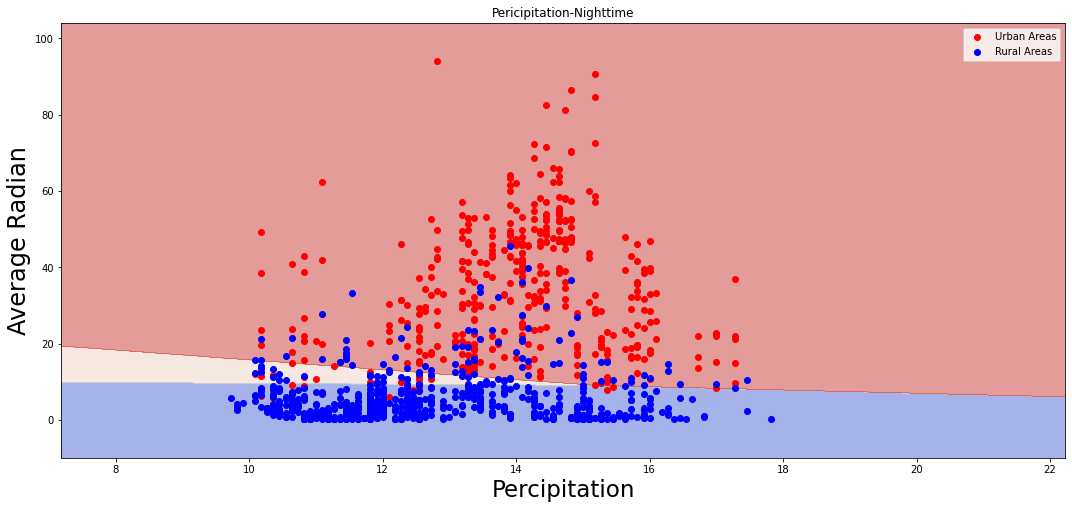

In [59]:
# The X axis (horizontal axis) is the percipitation
min_x, max_x = min(dataframe.pr.values)-1, max(dataframe.pr.values)+1
# The y axis (vertical axis) is the average radian
min_y, max_y = min(dataframe.avg_rad.values)-10, max(dataframe.avg_rad.values)+10
# define the steps
step = 0.05

xx , yy = np.meshgrid(np.arange(min_x, max_x, step), np.arange(min_y, max_y, step))
Z = svm_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(18, 8))
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.5)
plt.title("Pericipitation-Nighttime")
plt.xlabel("Percipitation", fontsize=23)
plt.ylabel("Average Radian", fontsize=24)
# urban
plt.scatter(dataframe[dataframe["smod_code"] == 3].pr,
            dataframe[dataframe["smod_code"] == 3].avg_rad, color="red", label="Urban Areas")
# rural
plt.scatter(dataframe[dataframe["smod_code"] == 1].pr,
            dataframe[dataframe["smod_code"] == 1].avg_rad, color="blue", label="Rural Areas")
plt.legend()


# SVM Classification (Non-Linear)

In [74]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
svm_clf_nonlinear = Pipeline(
    [
        ("standard", StandardScaler()),
        ("linear_svc", SVC(kernel="rbf", gamma=10, C=1))
    ])


# Fit the train data to model

In [75]:
svm_clf_nonlinear.fit(X_train, y_train)
print("Accuracy = ", round(svm_clf_nonlinear.score(X_test, y_test)*100), "%", sep="")


Accuracy = 78%


# Plot the classification

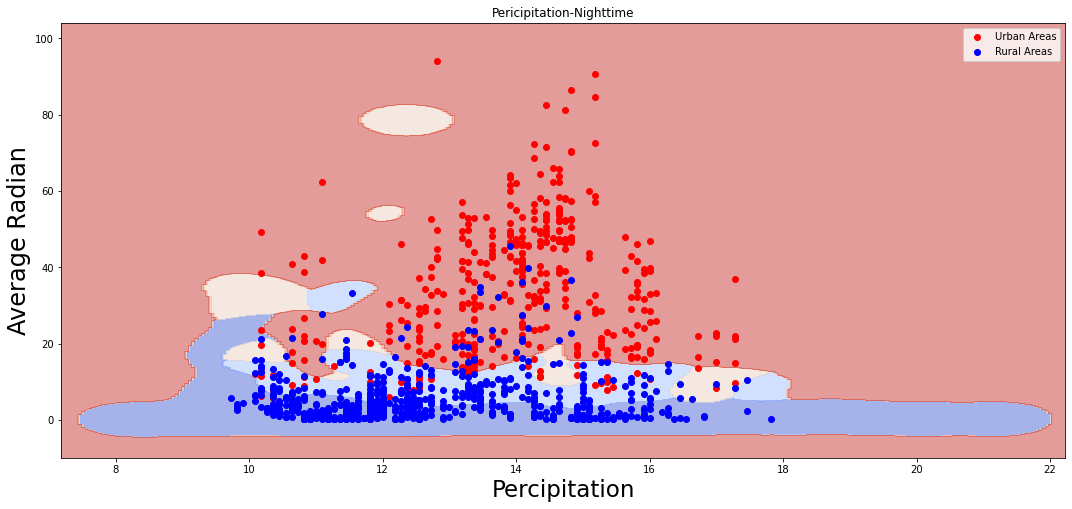

In [76]:
# The X axis (horizontal axis) is the percipitation
min_x, max_x = min(dataframe.pr.values)-1, max(dataframe.pr.values)+1
# The y axis (vertical axis) is the average radian
min_y, max_y = min(dataframe.avg_rad.values) - \
    10, max(dataframe.avg_rad.values)+10
# define the steps
step = 0.05

xx, yy = np.meshgrid(np.arange(min_x, max_x, step),
                     np.arange(min_y, max_y, step))
Z = svm_clf_nonlinear.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(18, 8))
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.5)
plt.title("Pericipitation-Nighttime")
plt.xlabel("Percipitation", fontsize=23)
plt.ylabel("Average Radian", fontsize=24)
# urban
plt.scatter(dataframe[dataframe["smod_code"] == 3].pr,
            dataframe[dataframe["smod_code"] == 3].avg_rad, color="red", label="Urban Areas")
# rural
plt.scatter(dataframe[dataframe["smod_code"] == 1].pr,
            dataframe[dataframe["smod_code"] == 1].avg_rad, color="blue", label="Rural Areas")
plt.legend()
